*NOTE:* I initially attempted this simulation with SimPy, but ran into an issue I couldn't overcome! Specifically, the various `env.now()` method was not syncing across objects, and as a result, the calculation of waiting time was off. So, I had to re-create the simulation in base Python. It still runs efficiently, reasonably models the desired process (traffic intersection), and provides some more transparency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## Functions

### Single simulation

This function performs a single simulation of a traffic intersection. It loops through a single second, for as many seconds as dictated by `simulation_duration`. It makes the following simplifying assumptions:  
1. The intersection consists of two one-way streets.
2. The traffic light has only Green and Red lights (no Yellow).
3. Lights change instantaneously. While Light A is Green, Light B is Red, and vice versa.
4. Vehicles that that arrive to the intersection while their respective light is Green are able to pass through without waiting.
5. Vehicles that arrive while their respective light is Red enter a queue to wait. Once their light turns Green, the first car in queue passes through instantly. Then, each additional car in queue passes through at one second intervals.

Key parameters to designate are as follows:
1. Arrival rates, which dictate how frequently vehicles arrive at each of the two streets. It is formulated as vehicles per second, but a random check is added to introduce some "noise" and some degree of realism. 
2. Green light durations, which dictate how long each street's light remains Green. It is measured in seconds.
3. Simulation duration, which dictates how long the total simulation lasts.

The simulation runs on a one-second loop. During each iteration of this loop, the arrival check is performed to see if a new vehicle will arrive at either of the streets. Any vehicles waiting in queue check whether their light has turned Green, and if so, they will pass through or move up in the queue.

The key goal is to identify optimal combinations of Green light durations for each light that minimize waiting, given different arrival rates.

In [2]:
def traffic_simulation(
        arrival_rate_A, arrival_rate_B, 
        green_light_duration_A, green_light_duration_B, 
        simulation_duration, printing=False
    ):
    
    # Queues for the streets (each element is a tuple: (arrival_time, vehicle_number))
    queue_A = []
    queue_B = []

    # Counters for passed vehicles and wait times
    passed_A = 0
    passed_B = 0
    wait_times_A = []
    wait_times_B = []

    # Vehicle number counter
    vehicle_number = 1

    # Helper function to simulate vehicle arrivals
    def simulate_arrival(rate):
        return np.random.random() < rate

    # Create schedule of light changes
    schedule = [0]
    while schedule[-1] < simulation_duration:
        schedule.append(schedule[-1] + green_light_duration_A)
        schedule.append(schedule[-1] + green_light_duration_B)
    light_status = 'B'
    next_light_change = schedule[1]

    # Simulation loop
    current_time = 0
    while current_time < simulation_duration:
        # Determine the current phase (which light is green)
        if current_time in schedule:
            light_status = 'A' if light_status == 'B' else 'B'
            next_light_change = schedule[schedule.index(current_time) + 1]
        
        # Print light change
        if printing: 
            print(f"\n--Time: {current_time}s, Light: {light_status} is green. Light will change at: {next_light_change}s")

        # Process vehicles passing through the intersection
        while current_time < next_light_change and current_time < simulation_duration:
            # Simulate vehicle arrivals
            if simulate_arrival(arrival_rate_A):
                queue_A.append((current_time, vehicle_number))
                if printing:
                    print(f"Vehicle {vehicle_number} arrived at street A at time {current_time}s")
                vehicle_number += 1
            if simulate_arrival(arrival_rate_B):
                queue_B.append((current_time, vehicle_number))
                if printing:
                    print(f"Vehicle {vehicle_number} arrived at street B at time {current_time}s")
                vehicle_number += 1
            
            # Vehicles passing through the intersection
            if light_status == 'A' and queue_A:
                arrival_time, vehicle_num = queue_A.pop(0)
                wait_time = current_time - arrival_time
                wait_times_A.append(wait_time)
                passed_A += 1
                if printing:
                    print(f"Vehicle {vehicle_num} from street A passed at time {current_time}. Wait time: {wait_time}s")
            if light_status == 'B' and queue_B:
                arrival_time, vehicle_num = queue_B.pop(0)
                wait_time = current_time - arrival_time
                wait_times_B.append(wait_time)
                passed_B += 1
                if printing:
                    print(f"Vehicle {vehicle_num} from street B passed at time {current_time}. Wait time: {wait_time}s")
            
            # Increment time
            current_time += 1

    # Calculate average wait times
    average_wait_time_A = sum(wait_times_A) / len(wait_times_A) if wait_times_A else 0
    average_wait_time_B = sum(wait_times_B) / len(wait_times_B) if wait_times_B else 0
    total_avg_wait_time = (sum(wait_times_A) + sum(wait_times_B)) / (len(wait_times_A) + len(wait_times_B)) if wait_times_A or wait_times_B else 0

    return average_wait_time_A, average_wait_time_B, total_avg_wait_time

### Repeat Simulations

This function runs repeated simulations, with combinations of durations for Green Lights A and B. It used the same arrival rates for all simulations. It outputs matrices detailing the average wait times at each light for each simulation, as well as an aggregated wait time that considers both lights. It also outputs the respective durations that map to each index of these matrices, to support plotting.

In [3]:
def run_simulations(arrival_rate_A, arrival_rate_B, green_light_durations_A, green_light_durations_B, simulation_duration):
    # Initialize results arrays
    avg_wait_times_A = np.zeros((len(green_light_durations_A), len(green_light_durations_B)))
    avg_wait_times_B = np.zeros((len(green_light_durations_A), len(green_light_durations_B)))
    total_avg_wait_times = np.zeros((len(green_light_durations_A), len(green_light_durations_B)))
    durations_A = np.zeros((len(green_light_durations_A), len(green_light_durations_B)))
    durations_B = np.zeros((len(green_light_durations_A), len(green_light_durations_B)))

    # Run simulations for varied green light durations
    for i, duration_A in enumerate(green_light_durations_A):
        for j, duration_B in enumerate(green_light_durations_B):
            avg_wait_time_A, avg_wait_time_B, total_avg_wait_time = traffic_simulation(
                arrival_rate_A, arrival_rate_B, duration_A, duration_B, simulation_duration)
            avg_wait_times_A[i, j] = avg_wait_time_A
            avg_wait_times_B[i, j] = avg_wait_time_B
            total_avg_wait_times[i, j] = total_avg_wait_time
            durations_A[i, j] = duration_A
            durations_B[i, j] = duration_B

    return avg_wait_times_A, avg_wait_times_B, total_avg_wait_times, durations_A, durations_B

### Plot Results

This function generates three response curve spots, highlighting the relationship of green light durations at each light to the wait times for:
1. Street A;
2. Street B; and
3. Both Streets combined.

It also prints the combination of durations that produce the minimal wait times.

In [4]:
def plot_results(durations_A, durations_B, avg_wait_times_A, avg_wait_times_B, total_avg_wait_times):

    # Find optimal combinations
    min_idx_A = np.unravel_index(np.argmin(avg_wait_times_A), avg_wait_times_A.shape)
    min_idx_B = np.unravel_index(np.argmin(avg_wait_times_B), avg_wait_times_B.shape)
    min_idx_agg = np.unravel_index(np.argmin(total_avg_wait_times), total_avg_wait_times.shape)

    print(
        f"Optimal combination for Street A wait times: A = {durations_A[min_idx_A]}, B = {durations_B[min_idx_A]}"
        f"\nOptimal combination for Street B wait times: A = {durations_A[min_idx_B]}, B = {durations_B[min_idx_B]}"
        f"\nOptimal combination for total wait times: A = {durations_A[min_idx_agg]}, B = {durations_B[min_idx_agg]}"
    )

    # Plotting the results
    X = durations_A
    Y = durations_B
    fig = plt.figure(figsize=(18, 6))

    # Average wait times for street A
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, avg_wait_times_A, cmap='viridis')
    ax1.set_title('Average Wait Times for Street A')
    ax1.set_xlabel('Green Light Duration A (s)')
    ax1.set_ylabel('Green Light Duration B (s)')
    ax1.set_zlabel('Avg Wait Time (s)')
    ax1.set_box_aspect((1, 1, 1), zoom=0.8)

    # Average wait times for street B
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, avg_wait_times_B, cmap='plasma')
    ax2.set_title('Average Wait Times for Street B')
    ax2.set_xlabel('Green Light Duration A (s)')
    ax2.set_ylabel('Green Light Duration B (s)')
    ax2.set_zlabel('Avg Wait Time (s)')
    ax2.set_box_aspect((1, 1, 1), zoom=0.8)

    # Total average wait times
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X, Y, total_avg_wait_times, cmap='inferno')
    ax3.set_title('Total Average Wait Times')
    ax3.set_xlabel('Green Light Duration A (s)')
    ax3.set_ylabel('Green Light Duration B (s)')
    ax3.set_zlabel('Total Avg Wait Time (s)')
    ax3.set_box_aspect((1, 1, 1), zoom=0.8)

    plt.tight_layout()
    plt.show()

To validate the function of the simulation, I've added a printing function that prints the status during the following key events:
1. Light changes
2. Vehicle arrivals
3. Vehicles passes

Each event includes a time stamp, and all vehicle passes identify the wait time (even if a vehicle arrives during a Green light, in which case wait time is zero).

We can see from the details below that vehicles function as expected. 
- Vehicle 1, for example, arrives at Street A when Light A is Green. It arrives at 5 seconds, passes through at 5 seconds, and has a wait time of 0.
- By contrast, Vehicle 2 arrives at Street B at 14 seconds while Light B is Red. As a result, it does not pass through and instead enters the queue. During that first light, Vehicles 6 and 7 also arrive at Street B and must wait. 
- Once Light B changes to Green at 45 seconds, Vehicle 2 passes through the light first. Its wait time is correctly measured at 31 seconds (it arrived at 14 seconds and passed through at 45 seconds). Then, each additional vehicle in the queue (numbers 6 and 7) pass through in order at one second intervals.

In [5]:
traffic_simulation(
    arrival_rate_A=0.05, arrival_rate_B=0.08,
    green_light_duration_A=45, green_light_duration_B=15, 
    simulation_duration=120, printing=True
)


--Time: 0s, Light: A is green. Light will change at: 45s
Vehicle 1 arrived at street A at time 5s
Vehicle 1 from street A passed at time 5. Wait time: 0s
Vehicle 2 arrived at street B at time 14s
Vehicle 3 arrived at street A at time 21s
Vehicle 3 from street A passed at time 21. Wait time: 0s
Vehicle 4 arrived at street A at time 29s
Vehicle 4 from street A passed at time 29. Wait time: 0s
Vehicle 5 arrived at street A at time 36s
Vehicle 5 from street A passed at time 36. Wait time: 0s
Vehicle 6 arrived at street B at time 38s
Vehicle 7 arrived at street B at time 41s

--Time: 45s, Light: B is green. Light will change at: 60s
Vehicle 2 from street B passed at time 45. Wait time: 31s
Vehicle 6 from street B passed at time 46. Wait time: 8s
Vehicle 7 from street B passed at time 47. Wait time: 6s
Vehicle 8 arrived at street A at time 49s
Vehicle 9 arrived at street A at time 50s
Vehicle 10 arrived at street B at time 54s
Vehicle 10 from street B passed at time 54. Wait time: 0s

--Tim

(2.4444444444444446, 13.0, 7.411764705882353)

To determine the appropriate number of iterations (i.e. simulation length), we'll run a fixed simulation for varied duration and look for convergence. We see significant differences in results when using 60 versus 600 versus 6000 iterations. Above that, however, we see only minimal difference. Given the relative efficiency of the simulation (even 600,000 iterations took less than 10 seconds to run), we'll use a `simulation_duration` of 60,000 seconds (or 1000 minutes).

In [6]:
results = {}

for sim_duration in [60, 600, 6000, 60000, 600000]:
    result = traffic_simulation(
        arrival_rate_A=0.05, arrival_rate_B=0.05,
        green_light_duration_A=30, green_light_duration_B=30, 
        simulation_duration=sim_duration, printing=False
    )
    
    print(f"Average wait times for simulation duration {sim_duration}: {np.round(result, 2)}")

Average wait times for simulation duration 60: [0.   3.5  2.33]
Average wait times for simulation duration 600: [7.13 6.53 6.84]
Average wait times for simulation duration 6000: [7.64 8.11 7.88]
Average wait times for simulation duration 60000: [8.23 8.25 8.24]
Average wait times for simulation duration 600000: [8.13 8.21 8.17]


Next, we run a series of simulations, each with a different combination of green light durations. We generate response curve plots, and they align to expectations. It is important to note that, for these simulations, we use **equal arrival rates** for both streets.

Looking at the first plot, which puts wait times for Street A on the Z axis, we see that, as green light durations for Light B increase, so do wait times for Street A. Similarly, as durations for Light A increase, wait times for Street A *decrease*. We see a similar pattern in the second plot for Street B wait times (but flipped!).

Looking at the third plot, which shows aggregated wait times across both streets, we have our first real insight. It seems that, with equal arrival rates, aggregate wait time is minimized with very short green light durations. This sounds reasonable, as longer durations will cause more vehicles to arrive at the intersection during Red lights.

Optimal combination for Street A wait times: A = 42.0, B = 15.0
Optimal combination for Street B wait times: A = 15.0, B = 42.0
Optimal combination for total wait times: A = 15.0, B = 15.0


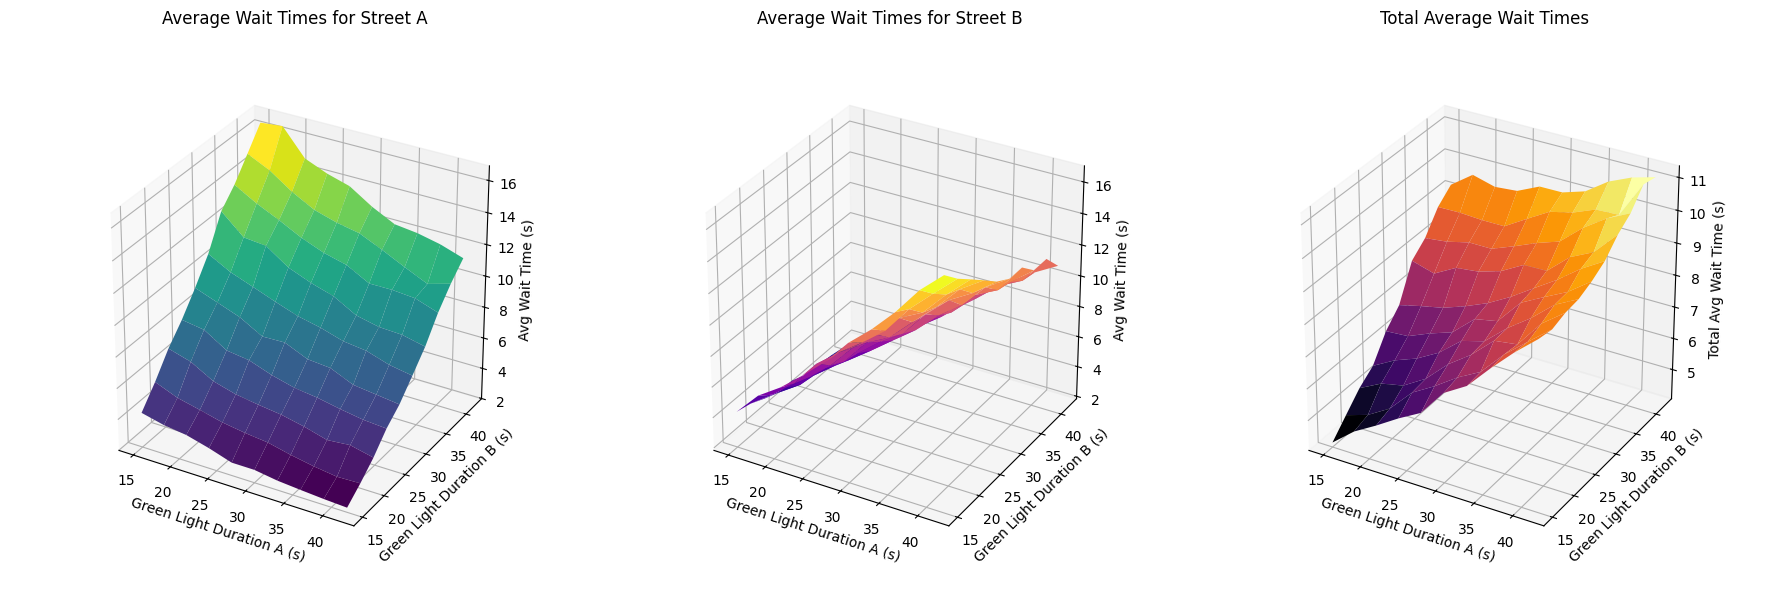

In [7]:
# Parameters
arrival_rate_A = 0.05
arrival_rate_B = 0.05
simulation_duration = 60000

# Range of green light durations to test
green_light_durations_A = np.arange(15, 45, 3)
green_light_durations_B = np.arange(15, 45, 3)

# Run simulations
avg_wait_times_A, avg_wait_times_B, total_avg_wait_times, durations_A, durations_B = run_simulations(
    arrival_rate_A, arrival_rate_B, 
    green_light_durations_A, green_light_durations_B, 
    simulation_duration
)

# Plot results
plot_results(durations_A, durations_B, avg_wait_times_A, avg_wait_times_B, total_avg_wait_times)

Next, we re-perform the series of simulations, but with **varied arrival rates**. While the patterns for Streets A and B are consistent (as expected), we see the optimal combination for aggregate wait times change. With a more frequent arrival rate on Street A, aggregate wait times are minimized by increasing the duration of green lights for Light A, while keeping durations for Light B as low as possible.

Optimal combination for Street A wait times: A = 42.0, B = 15.0
Optimal combination for Street B wait times: A = 15.0, B = 42.0
Optimal combination for total wait times: A = 15.0, B = 15.0


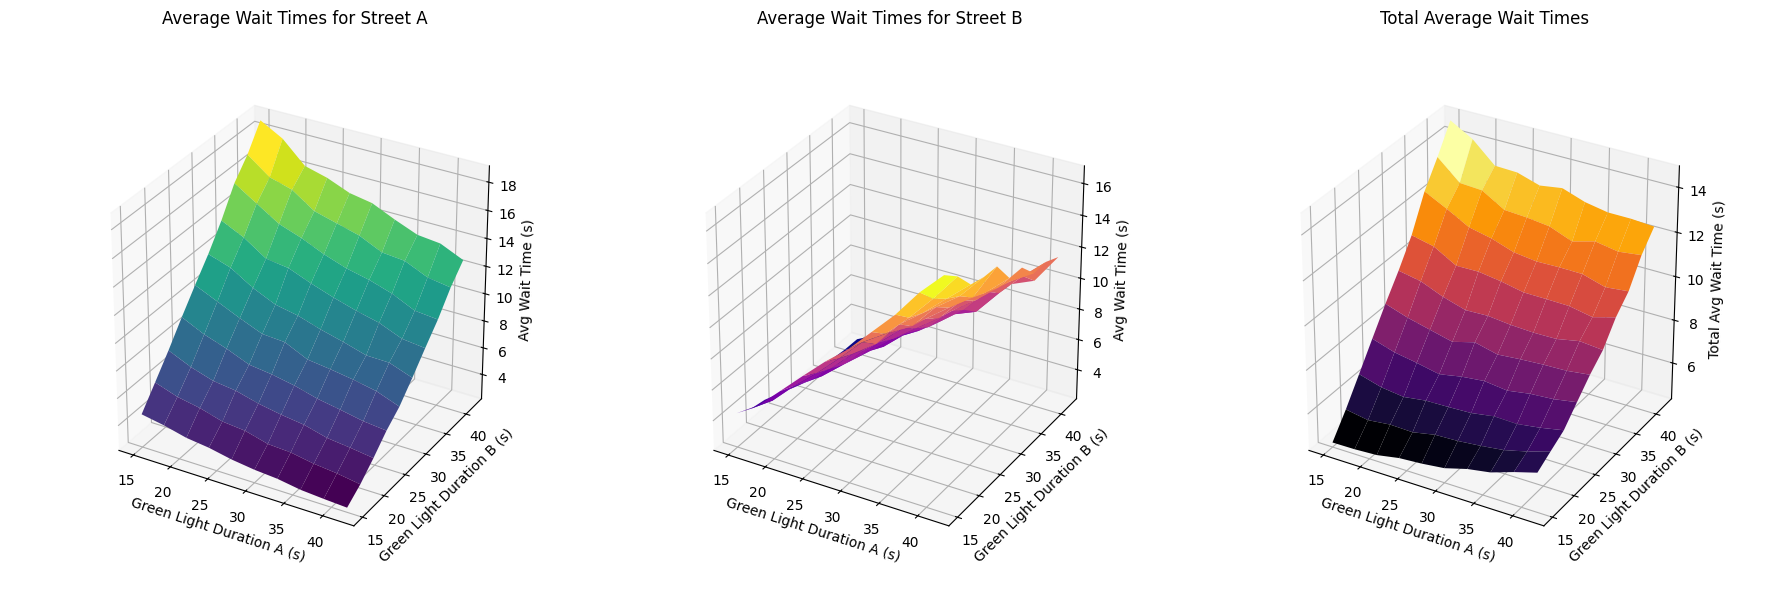

In [8]:
# Parameters - the considered green light durations remain the same
arrival_rate_A = 0.15  
arrival_rate_B = 0.05 

# Run simulations
avg_wait_times_A, avg_wait_times_B, total_avg_wait_times, durations_A, durations_B = run_simulations(
    arrival_rate_A, arrival_rate_B, 
    green_light_durations_A, green_light_durations_B, 
    simulation_duration
)

# Plot results
plot_results(durations_A, durations_B, avg_wait_times_A, avg_wait_times_B, total_avg_wait_times)

We see the same pattern hold true when the arrival rates are reversed, as well.

Optimal combination for Street A wait times: A = 42.0, B = 15.0
Optimal combination for Street B wait times: A = 15.0, B = 39.0
Optimal combination for total wait times: A = 15.0, B = 18.0


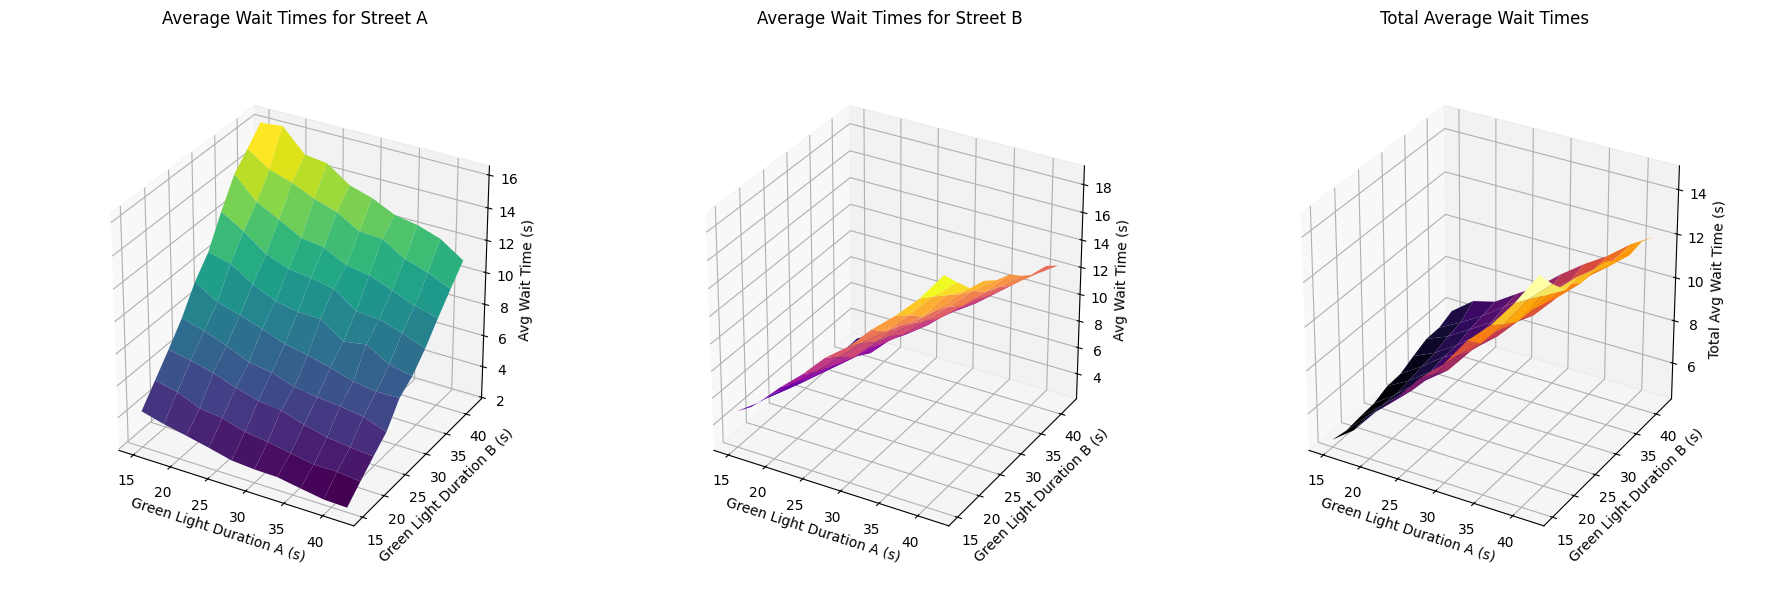

In [9]:
# Parameters - the considered green light durations remain the same
arrival_rate_A = 0.05 
arrival_rate_B = 0.15

# Run simulations
avg_wait_times_A, avg_wait_times_B, total_avg_wait_times, durations_A, durations_B = run_simulations(
    arrival_rate_A, arrival_rate_B, 
    green_light_durations_A, green_light_durations_B, 
    simulation_duration
)

# Plot results
plot_results(durations_A, durations_B, avg_wait_times_A, avg_wait_times_B, total_avg_wait_times)

We can assess a few more extreme scenarios, where the disparity of arrivals is even greater. In all these cases, it is notable that the optimal combination of durations *never* includes the maximal allowed time for a green light (45 seconds). This suggests that there is some upper limit for duration, past which the lights introduce additional wait times.

It is also notable that the response curves become much steeper, indicating greater sensitivity to changes in duration within certain ranges.

Optimal combination for Street A wait times: A = 42.0, B = 15.0
Optimal combination for Street B wait times: A = 15.0, B = 42.0
Optimal combination for total wait times: A = 33.0, B = 15.0


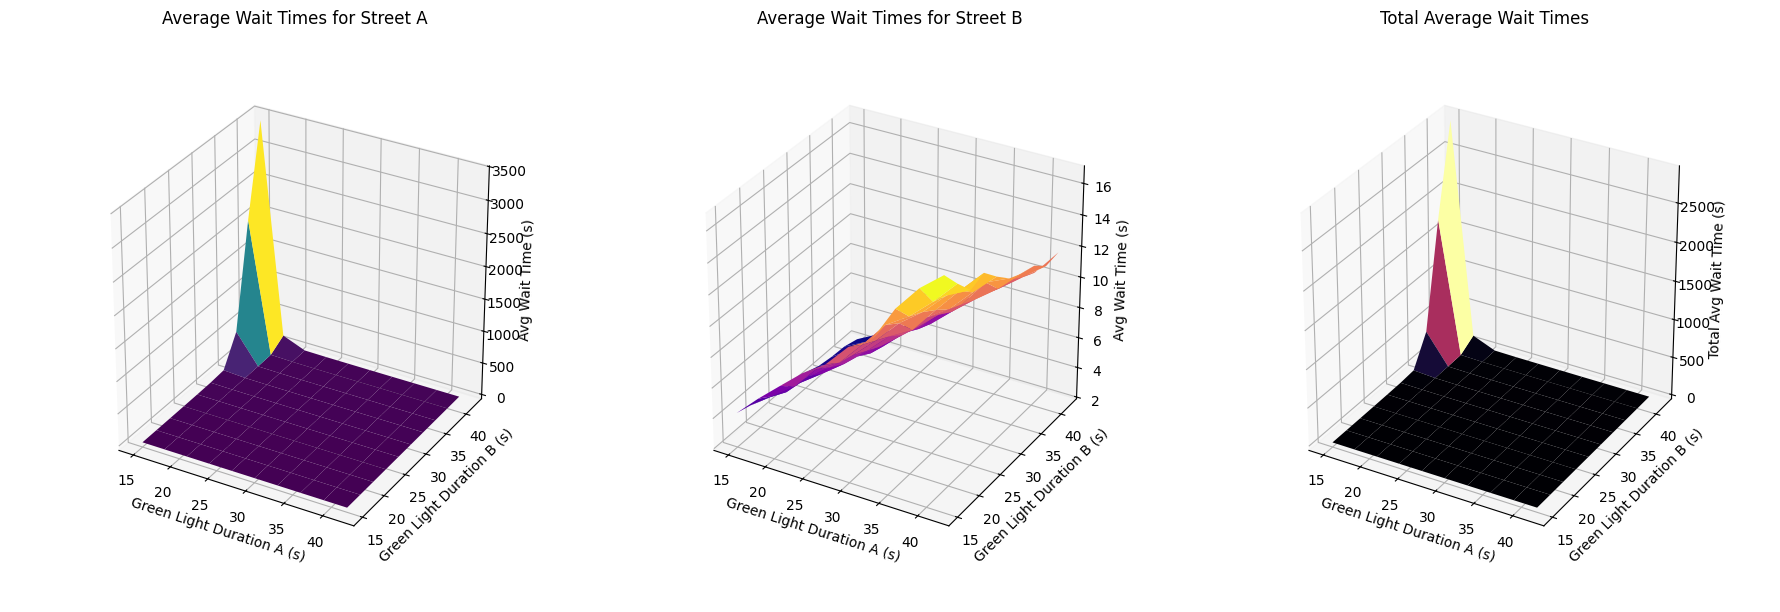

In [10]:
# Parameters - the considered green light durations remain the same
arrival_rate_A = 0.30 
arrival_rate_B = 0.05 

# Run simulations
avg_wait_times_A, avg_wait_times_B, total_avg_wait_times, durations_A, durations_B = run_simulations(
    arrival_rate_A, arrival_rate_B, 
    green_light_durations_A, green_light_durations_B, 
    simulation_duration
)

# Plot results
plot_results(durations_A, durations_B, avg_wait_times_A, avg_wait_times_B, total_avg_wait_times)

Optimal combination for Street A wait times: A = 42.0, B = 15.0
Optimal combination for Street B wait times: A = 15.0, B = 42.0
Optimal combination for total wait times: A = 42.0, B = 15.0


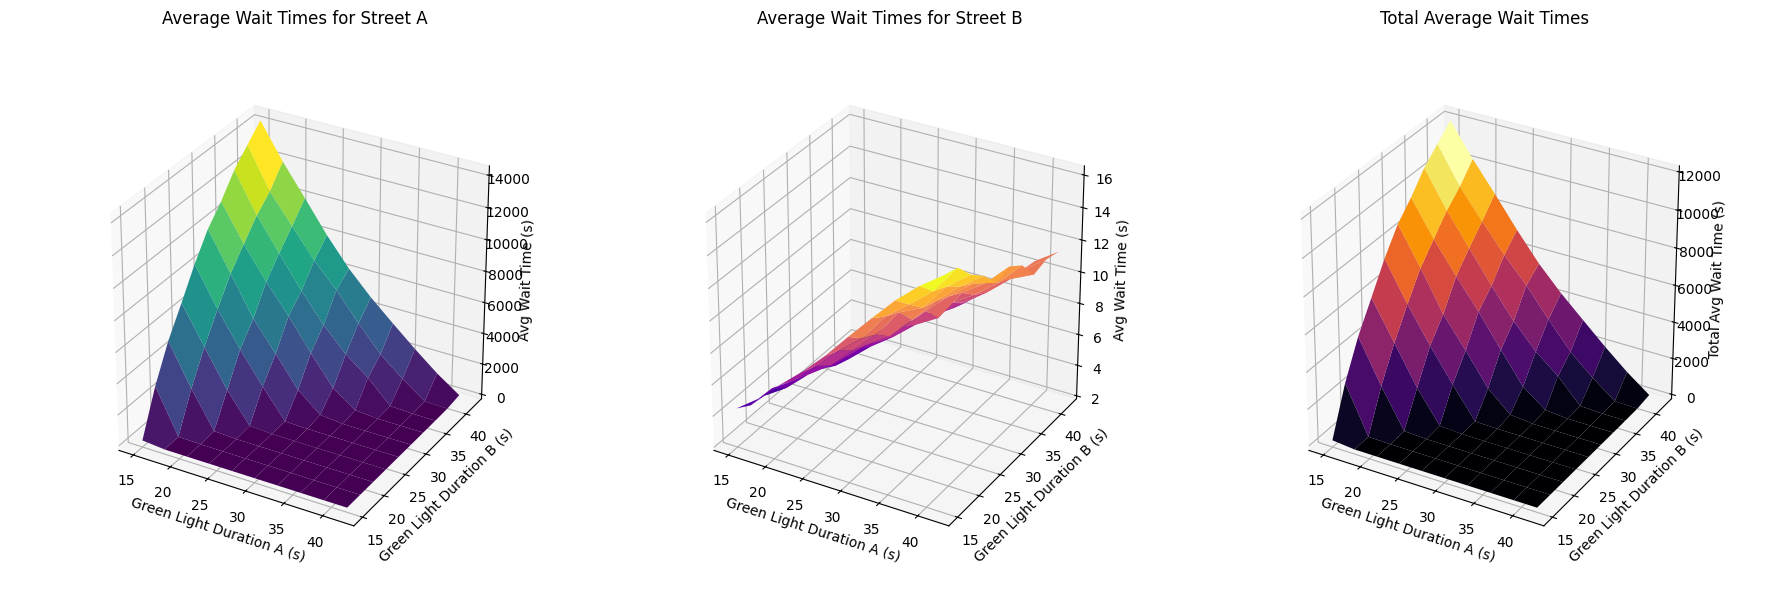

In [11]:
# Parameters - the considered green light durations remain the same
arrival_rate_A = 0.50  
arrival_rate_B = 0.05  

# Run simulations
avg_wait_times_A, avg_wait_times_B, total_avg_wait_times, durations_A, durations_B = run_simulations(
    arrival_rate_A, arrival_rate_B, 
    green_light_durations_A, green_light_durations_B, 
    simulation_duration
)

# Plot results
plot_results(durations_A, durations_B, avg_wait_times_A, avg_wait_times_B, total_avg_wait_times)

Optimal combination for Street A wait times: A = 42.0, B = 15.0
Optimal combination for Street B wait times: A = 15.0, B = 42.0
Optimal combination for total wait times: A = 42.0, B = 15.0


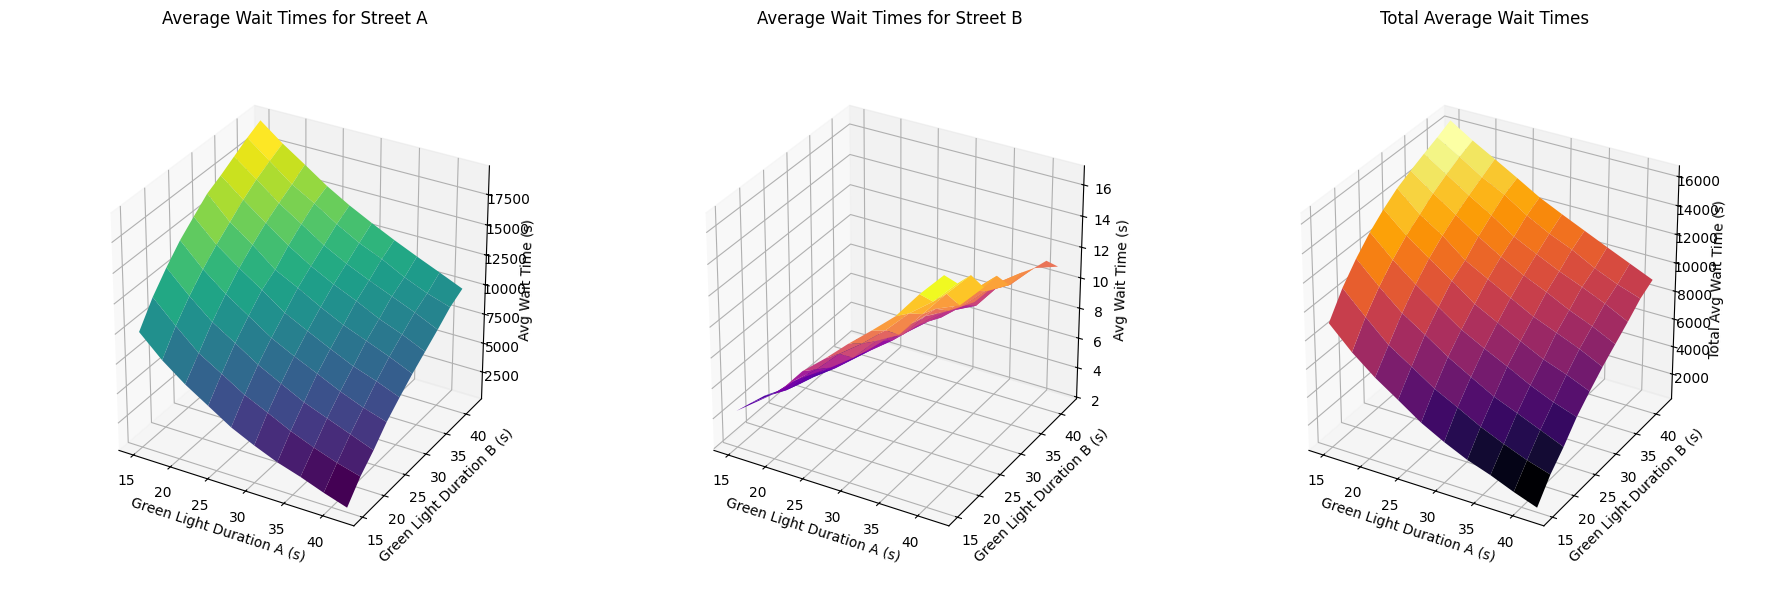

In [12]:
# Parameters - the considered green light durations remain the same
arrival_rate_A = 0.75  
arrival_rate_B = 0.05  

# Run simulations
avg_wait_times_A, avg_wait_times_B, total_avg_wait_times, durations_A, durations_B = run_simulations(
    arrival_rate_A, arrival_rate_B, 
    green_light_durations_A, green_light_durations_B, 
    simulation_duration
)

# Plot results
plot_results(durations_A, durations_B, avg_wait_times_A, avg_wait_times_B, total_avg_wait_times)

## Conclusions

Within this simplified scenario, a few key takeaways become clear.
1. Given similar arrival rates, increasing the green light duration for a given street typically reduces wait times for that street, but may increase wait times at the intersectiong street.
2. With equal arrival rates, aggregate wait time appears minimized by keeping green light durations very low.
3. As arrival rates diverge, aggregate wait time can be reduced by increasing the green light duration for the street with a greater arrival rate. However, there appears to be an upper limit, past which additional green light time will increase aggregate wait times.

It is also important to acknowledge some key limitations of these simulations. Most important, we do not consider the frictions of stopping and starting (i.e. acceleration or deceleration, yellow lights, short periods where both lights must be red). While our simulation that very short green light durations can reduce wait times, in reality, these frictions could reduce the benefit of such short durations. Moreover, such short green light times could increase the incentive for running red lights and increase the likelihood of accidents. In the future, this simulation could be enhanced by introducing more of these real world considerations.